# HWRS 528 IMP03
## Build Catchment Model

### 1. Import Python Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2. Define Function Subprograms
#### 2.1 Catchment model subprograms

In [22]:
#==== Linear reservoir module (for one time step) ================================

def LinRes(Xin, U, Kpar):                   # Define LinRes function subprogram

    Y = Kpar*Xin                            # Compute QQ
    Xout = Xin - Y + U                      # Update state variable

    return [Y, Xout]                        # Return computed quantities

#==== Channel routing module (for one time step) ====================================================

def NashCasc(OF, NRes, XX3in, Theta_K3Q):   # Define NashCasc function subprogram

    ResIdx = np.arange(0, NRes, 1)          # Set loop vector on tanks (int values)
    UU     = OF                             # UU is set to be input to first tank
    XX3out = np.zeros(NRes)                 # Initialize array to recieve XX3out
    YY     = np.zeros(NRes)                 # Initialize array to recieve YY (individual tank outflows)

    for i in ResIdx:
        [YY[i], XX3out[i]] = LinRes(XX3in[i], UU, Theta_K3Q)
        UU = YY[i]                          # set UU (inflow to next tank) to be outflow from previous tank
    SF = UU                                 # Get output from last tank

    return [SF, XX3out]                     # Return computed quantities (surface flow and state variable of last tank)

#==== Lower Soil Zone Module (for one time step) ======================================================

def LowerSoilZone(XX2in, RG, Theta_K2Q):    # Calculate lower soil zone subprocesses using LinRes

    [BF, XX2out] = LinRes(XX2in, RG, Theta_K2Q) # Use Recharge as input for LSZ from upper soil zone tank
    return [BF, XX2out]

#==== Upper Soil Zone Module (for one time step) ======================================================

def UpperSoilZone(XX1in, PP, PE, Theta_C1, Theta_P1, Theta_K13, Theta_K12):
    
    PX   = np.maximum(0, PP + XX1in - Theta_C1)   # Determines excess precipitation, part 1 of OF
    IF   = Theta_K13*XX1in                        # Determines lateral drainage, part 2 of OF
    OF   = PX + IF                                # Overland flow that will become the input for NashCasc
    XX1a = XX1in - IF                             # Remainder of water content (Method of Operator Splitting)
    AE   = np.minimum(XX1a, PE*(XX1a/Theta_C1)**Theta_P1) # Actual evaporation limited by PE or water content
    XX1b = XX1a - AE                              # Remainder of water content 
    RG   = Theta_K12*XX1b                         # Recharge
    XX1c = XX1b - RG                              # Remainder of water content
    XX1out = XX1c + PP - PX                       # State variable at end of time step

    return [OF, PX, IF, AE, RG, XX1out]

#==== Catchment Model (for one time step) ======================================================

def CatchModel(Inputs, InStates, Pars, NRes):

    # Get input values for time step
    PP = Inputs[0]
    PE = Inputs[1]

    # Get state values at beginning of time step
    XX1in  = InStates[0]
    XX2in  = InStates[1]
    XX3in  = np.zeros(NRes)
    ResIdx = np.arange(0, NRes, 1)
    for i in ResIdx:
        XX3in[i] = InStates[i+2]

    # Get Par values
    Theta_C1  = Pars[0]
    Theta_P1  = Pars[1]
    Theta_K12 = Pars[2]
    Theta_K13 = Pars[3]
    Theta_K2Q = Pars[4]
    Theta_K3Q = Pars[5]

    # Initialize Output array
    Outputs   = np.zeros(2)
    OutStates = np.zeros(NRes+2)
    IntFluxes = np.zeros(6)

    # Run model components
    [OF, PX, IF, AE, RG, XX1out] = UpperSoilZone(XX1in, PP, PE,
                                                Theta_C1, Theta_P1,
                                                Theta_K13, Theta_K12)
    [BF, XX2out] = LowerSoilZone(XX2in, RG, Theta_K2Q)
    [SF, XX3out] = NashCasc(OF, NRes, XX3in, Theta_K3Q)
    QQ           = SF + BF

    # Compile outputs for time step
    Outputs[0] = QQ
    Outputs[1] = AE

    # Compile and get state values at end of time step
    OutStates[0] = XX1out
    OutStates[1] = XX2out
    for i in ResIdx:
        OutStates[i+2] = XX3out[i]

    # Compile internal fluxes for time step
    IntFluxes[0] = OF; IntFluxes[1] = PX; IntFluxes[2] = IF
    IntFluxes[3] = RG; IntFluxes[4] = BF; IntFluxes[5] = SF

    return [Outputs, OutStates, IntFluxes]

def MainCatchModel(PPobs, PEobs, Theta_C1,
                   Theta_P1, Theta_K12, Theta_K13,
                   Theta_K2Q, Theta_K3Q, NRes):
    
    
    NTime = len(PPobs)              # Get length of time vector
    Time  = np.arange(0, NTime, 1)  # Set up time vector (of integer values)

    # Pack parameter values in Par array
    Npar = 6; Pars = np.zeros(Npar)
    Pars[0] = Theta_C1;  Pars[1] = Theta_P1;  Pars[2] = Theta_K12
    Pars[3] = Theta_K13; Pars[4] = Theta_K2Q; Pars[5] = Theta_K3Q

    # Initialize model state arrays
    InStates = np.zeros(NRes+2); OutStates = InStates.copy()
    InStates[1] = QQobs[0]/Theta_K2Q

    # Initialize arrays
    Inputs = np.zeros(2); Outputs = np.zeros(2); IntFluxes = np.zeros(6)
    QQsim  = np.zeros(NTime); AEsim = np.zeros(NTime)

    OF = np.zeros(NTime); PX = np.zeros(NTime); IF = np.zeros(NTime)
    RG = np.zeros(NTime); BF = np.zeros(NTime); SF = np.zeros(NTime)
    XX1 = np.zeros(NTime+1); XX2 = np.zeros(NTime+1)
    XX3 = np.zeros([NTime+1, NRes])

    for t in Time:
        Inputs[0] = PPobs[t]; Inputs[1] = PEobs[t]
        [Outputs, OutStates, IntFluxes] = CatchModel(Inputs, InStates, Pars, NRes)

        QQsim[t] = Outputs[0].copy(); AEsim[t] = Outputs[1].copy()
        OF[t] = IntFluxes[0]; PX[t] = IntFluxes[1]; IF[t] = IntFluxes[2]
        RG[t] = IntFluxes[3]; BF[t] = IntFluxes[4]; SF[t] = IntFluxes[5]
        XX1[t+1] = OutStates[0]; XX2[t+1] = OutStates[1]
        ResIdx = np.arange(0, NRes, 1)
        for i in ResIdx:
            XX3[t+1, i] = OutStates[i+2]
        InStates = OutStates

    return [QQsim, AEsim]

#### 2.2 Metric Subprograms

In [32]:
#==== Compute Mean Square Error (MSE) ========================================

def MSE_Fn(Qs,Qo):                  # Define MSE_Fn function subprograms
    MSE = np.mean((Qs-Qo)**2)       # Compute MSE
    return MSE

#==== Compute NSE Metric

def NSE_Fn(Qs, Qo):                 # Define NSE_Fn function subprograms
    MSE = MSE_Fn(Qs,Qo)             # Compute MSE
    NSE = 1 - (MSE/np.var(Qo))      # Compute NSE
    return NSE

#==== Compute KGE Metric =====================================================

def KGE_Fn(Qs,Qo):                  # Define KGE_Fn function subprogram
    alpha = np.std(Qs)/np.std(Qo)                               # compute alpha
    beta  = np.mean(Qs)/np.mean(Qo)                             # compute beta
    rho   = np.corrcoef(Qs,Qo)[0,1]                             # compute rho
    KGE   = 1 - np.sqrt((1-alpha)**2 + (1-beta)**2 + (1-rho)**2)# compute KGE
    KGEss = (KGE - (1-np.sqrt(2)))/np.sqrt(2)                   # compute KGEss
    return [KGEss, KGE, alpha, beta, rho]   # Return compute quantities

#==== Compute all of the performance metrics (calls metric functions) ========

def PerfMetrics(QQsim, QQobs, SpinUp, iPrint):

    Qs   = QQsim[SpinUp:NTime].copy()                   # remove spin-up period
    Qo   = QQobs[SpinUp:NTime].copy()                   # remove spin-up period
    MSE  = MSE_Fn(Qs, Qo)                               # Compute MSE
    NSE  = NSE_Fn(Qs, Qo)                               # Compute NSE
    NSEL = NSE_Fn(np.log(Qs), np.log(Qo))               # Compute NSEL
    [KGEss, KGE, alpha, beta, rho] = KGE_Fn(Qs, Qo)     # Compute KGE & components

    # Create lables for printing
    MSELab = f'MSE = {MSE:.2f}'; NSELab = f'NSE = {NSE:.2f}'
    KGEssLab = f'KGEss = {KGEss:.2f}'; RhoLab = f'Rho = {rho:.2f}'
    AlphaLab = f'Alpha = {alpha:.2f}'; BetaLab = f'Beta = {beta:.2f}'
    NSELLab = f'NSEL = {NSEL:.2f}'

    if iPrint == 1: # print following lines only if the iPrint Flag is set to 1
        print()
        print('================================================================')
        print(MSELab, NSELab, KGEssLab, AlphaLab, BetaLab, RhoLab, NSELLab)
        print('================================================================')

    return [MSE,NSE,NSEL,KGEss,alpha,beta,rho]

##### 2.3 Diagnostics Plots subprograms

In [ ]:
#==== Create Diagnostics plots ===============================================

def DiagnosticsPlots(fignum, Time, QQsim, QQobs):
    

### 3. Begin Model Simulation for Leaf River
##### 3.1 Load data, choose time periods, and specify model parameters

In [19]:
#==== Load Leaf River Catchment Data as a DataFrame ============================
LRData = pd.read_csv('LeafRiverDaily.csv')

#==== Get number of data points ================================================
Ndata = LRData.shape[0]
Nvars = LRData.shape[1]

#==== Choose simulation time period and set up time vector =====================
Period_Start = 0; Period_End = 365*3                # select time period to work with
Time = np.arange(Period_Start, Period_End, 1)
NTime = len(Time)

#==== Set number of initial time steps to use as spin-up =======================
# Metrics are not computed on this period
SpinUp = 90                                         # select 90-day spin-up period

#==== Get data for the desired period ==========================================
PPobs = LRData.PP[Time].to_numpy()                  # Convert from DataFrame to numpy
PEobs = LRData.PE[Time].to_numpy()                  # arrays to avoid indexing issyes
QQobs = LRData.QQ[Time].to_numpy()

#==== Determine maximum values for each variable ===============================
PPobs_max = np.max(PPobs)
PEobs_max = np.max(PEobs)
QQobs_max = np.max(QQobs)

#==== Specify model parameters =================================================
NRes = 2; ResIdx = np.arange(0, NRes, 1)

#==== Specify model parameter values for simulation ============================
Theta_C1  = 60.0;    # Upper Soil Zone Capacity
Theta_P1  = 1.0;     # Evapotranspiration Parameter (Reducing value increases ET)  
Theta_K12 = 0.20;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
Theta_K13 = 0.10;    # Interflow Parameter (Increasing value increases Interflow)  
Theta_K2Q = 0.0001;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
Theta_K3Q = 0.6;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

##### 3.2 Run Catchment Model for Selected Time Period and View Metrics

In [23]:
# Run Catchment Model for Selected time period ================================
[QQsim, AEsim] = MainCatchModel(PPobs, PEobs, Theta_C1, Theta_P1, Theta_K12,
                                Theta_K13, Theta_K2Q, Theta_K3Q, NRes)

In [25]:
QQsim.shape

(1095,)

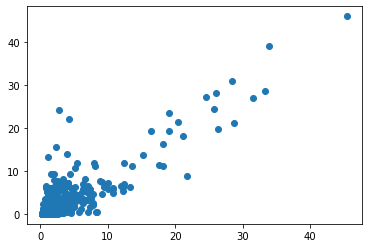

In [31]:
plt.scatter(QQsim, QQobs)